# Network Attack Prediction Analysis using HuggingFace Embeddings Model

>This notebook aims to demonstrate the application of Large Language Model (LLM) Embeddings in classification, specifically in the context of predicting the classification of network traffic logs as either 'normal' or 'attack'.

>The dataset used consists of 494,021 network traffic logs, each characterized by 42 attributes. These logs have already been transformed and labeled into a CSV file for easy ingestion into a pandas DataFrame.

>Initially, the labels are masked to represent only 'normal' and 'attack' classifications, simplifying the task to binary prediction.

>While Principal Component Analysis (PCA) is included for potential dimensionality reduction, the current analysis operates on the original dataset to assess its accuracy before any transformations.

>The dataset is then split into training and validation sets. These sets are converted into textual format to feed into the HuggingFace BGE embeddings model, which embeds each log into a numerical representation in a multidimensional vector space.

>Subsequently, FAISS, a library for similarity search and clustering of large datasets, is employed. The training embeddings are indexed, and a K-nearest neighbor search with K set to 1 is conducted for each validation log. This process determines the most similar network log for each validation element, facilitating the assignment of predictions.

>The notebook concludes with the computation of prediction accuracy to evaluate the performance of the classification model.

In [ ]:
!pip install -U scikit-learn
!python -m pip install -U pip
!python -m pip install -U matplotlib
!pip install langchain
!pip install sentence_transformers
!pip install tqdm
!pip install feature_engine
!pip install faiss-gpu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 68.9 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 32.8 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 23.1.2
    Uninstalling pip-23.1.2:
      Successfully uninstalled pip-23.1.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 73.9 MB/s eta 0:00:00
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.7.1
    Uninstalling matplotlib-3.7.1:
      Successfully uninstalled matplotlib-3.7.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 973.7/973.7 kB 48.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.9/307.9 kB 25.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Load the data

In [ ]:
import pandas as pd
from google.colab import drive

drive.mount('/content/gdrive')
df_train = pd.read_csv('gdrive/My Drive/Colab Notebooks/Independent Study/Automation of Data Analytics/trainingdata.csv')
df_train.head(5)



Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,tcp,http,SF,181,5450,0,0,0,0,...,9,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0,normal.
1,0,tcp,http,SF,239,486,0,0,0,0,...,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,normal.
2,0,tcp,http,SF,235,1337,0,0,0,0,...,29,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
3,0,tcp,http,SF,219,1337,0,0,0,0,...,39,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
4,0,tcp,http,SF,217,2032,0,0,0,0,...,49,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,normal.


Update label column to attack or normal

In [ ]:
# Create a mask for normal
normal_dot_mask = df_train['label'] == 'normal.'

# Update the 'label' column
df_train.loc[normal_dot_mask, 'label'] = 'normal'
df_train.loc[~normal_dot_mask, 'label'] = 'attack'

# Create the masks
normal_logs = df_train['label'] == 'normal'
attack_logs = df_train['label'] == 'attack'

print("Number of normal logs:", df_train[normal_logs].shape[0])
print("Number of attack logs:", df_train[attack_logs].shape[0])
df_train.head(100)

Number of normal logs: 97278
Number of attack logs: 396743


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,tcp,http,SF,181,5450,0,0,0,0,...,9,1.0,0.0,0.11,0.00,0.0,0.0,0.0,0.0,normal
1,0,tcp,http,SF,239,486,0,0,0,0,...,19,1.0,0.0,0.05,0.00,0.0,0.0,0.0,0.0,normal
2,0,tcp,http,SF,235,1337,0,0,0,0,...,29,1.0,0.0,0.03,0.00,0.0,0.0,0.0,0.0,normal
3,0,tcp,http,SF,219,1337,0,0,0,0,...,39,1.0,0.0,0.03,0.00,0.0,0.0,0.0,0.0,normal
4,0,tcp,http,SF,217,2032,0,0,0,0,...,49,1.0,0.0,0.02,0.00,0.0,0.0,0.0,0.0,normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0,tcp,http,SF,337,330,0,0,0,0,...,255,1.0,0.0,0.08,0.01,0.0,0.0,0.0,0.0,normal
96,0,tcp,http,SF,293,38125,0,0,0,0,...,255,1.0,0.0,0.05,0.01,0.0,0.0,0.0,0.0,normal
97,0,tcp,http,SF,171,280,0,0,0,0,...,255,1.0,0.0,0.17,0.02,0.0,0.0,0.0,0.0,normal
98,0,tcp,http,SF,178,1973,0,0,0,0,...,255,1.0,0.0,0.06,0.02,0.0,0.0,0.0,0.0,normal


In [ ]:
df_train.shape

(494021, 42)

In [ ]:
attack_logs.head(100)

0     False
1     False
2     False
3     False
4     False
      ...  
95    False
96    False
97    False
98    False
99    False
Name: label, Length: 100, dtype: bool

Check datatypes

In [ ]:
print(df_train.dtypes)

duration                         int64
protocol_type                   object
service                         object
flag                            object
src_bytes                        int64
dst_bytes                        int64
land                             int64
wrong_fragment                   int64
urgent                           int64
hot                              int64
num_failed_logins                int64
logged_in                        int64
num_compromised                  int64
root_shell                       int64
su_attempted                     int64
num_root                         int64
num_file_creations               int64
num_shells                       int64
num_access_files                 int64
num_outbound_cmds                int64
is_host_login                    int64
is_guest_login                   int64
count                            int64
srv_count                        int64
serror_rate                    float64
srv_serror_rate          

Split into numeric and text sets

In [ ]:
#Label Columns
text_columns = ['protocol_type', 'service', 'flag']
numerical_columns = df_train.drop(columns=text_columns + ['label']).columns.tolist()


df_text = df_train[text_columns]
df_numeric = df_train[numerical_columns]
df_label = df_train['label']

df_text.head()

,protocol_type,service,flag
0,tcp,http,SF
1,tcp,http,SF
2,tcp,http,SF
3,tcp,http,SF
4,tcp,http,SF


ONLY RUN IF YOU WANT TO NORMALIZE. Normalize and apply PCA to numeric features to reduce dimmension. Combine tables back together.

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

#Standardize the Numeric Data
scaler = StandardScaler()
X_train_numeric_scaled = scaler.fit_transform(df_numeric)

#Apply PCA while keeping 95% of the variance
pca = PCA(0.95)
X_train_pca = pca.fit_transform(X_train_numeric_scaled)

#Convert the PCA output back to a dataframe
df_pca = pd.DataFrame(X_train_pca, index=df_numeric.index)

#Concatenate with Textual Data
df_new_train = pd.concat([df_text, df_pca, df_label], axis=1)

In [ ]:
print(df_train.shape)

(494021, 42)


Split to training and validation sets

In [ ]:
from sklearn.model_selection import train_test_split

X = df_train.drop(columns=['label'])
y = df_train['label']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(395216, 41)
(98805, 41)
(395216,)
(98805,)


Make data textual

In [ ]:
X_train_textual = [' '.join(map(str, row)) for row in X_train.values]
X_val_textual = [' '.join(map(str, row)) for row in X_val.values]

In [ ]:
X_train_textual[0]

'0 icmp ecr_i SF 1032 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 511 511 0.0 0.0 0.0 0.0 1.0 0.0 0.0 255 255 1.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0'

Create embeddings model

In [ ]:
from langchain.embeddings import HuggingFaceBgeEmbeddings
embedding_model = HuggingFaceBgeEmbeddings(
    model_name="BAAI/bge-large-en-v1.5",
    model_kwargs={'device': 'cuda'},
    encode_kwargs={'normalize_embeddings': True}
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/94.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/779 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/191 [00:00<?, ?B/s]

Generate Embeddings

In [ ]:
from tqdm import tqdm


# Generate embeddings for training data using LangChain with progress bar and GPU acceleration
train_embeddings = []
for feature in tqdm(X_train_textual, desc="Generating train embeddings"):
    embeddings = embedding_model.embed_documents([feature])
    train_embeddings.append(embeddings[0])

# Generate embeddings for validation data using LangChain with progress bar and GPU acceleration
val_embeddings = []
for feature in tqdm(X_val_textual, desc="Generating validation embeddings"):
    embeddings = embedding_model.embed_documents([feature])
    val_embeddings.append(embeddings[0])

Generating validation embeddings: 100%|██████████| 98805/98805 [36:37<00:00, 44.97it/s]


In [ ]:
for x in range(10):
  print(train_embeddings[x])

[0.0025661864783614874, -0.0068488530814647675, 0.013255976140499115, 0.04984559118747711, -0.029320867732167244, -0.042294833809137344, -0.00395570183172822, 0.007482238579541445, -0.0047982665710151196, 0.08634702116250992, 0.042642902582883835, 0.024504711851477623, 0.04244389757514, -0.026601504534482956, -0.03779780492186546, -0.01594504714012146, -0.009578002616763115, -0.049456626176834106, -0.022174183279275894, -0.012806409038603306, 0.010221500881016254, 0.0061867330223321915, -0.06688407063484192, 0.007269568741321564, -0.05417509377002716, 0.06545990705490112, 0.025232642889022827, 0.0017600508872419596, 0.060283031314611435, 0.037958670407533646, 0.035379402339458466, -0.04511042684316635, 0.014381324872374535, -0.07349815964698792, 0.018406547605991364, -0.0282973051071167, 0.06066105142235756, -0.002894203644245863, -0.006137906573712826, -0.037184130400419235, 0.022915584966540337, -0.04515812546014786, 0.02187829278409481, -0.050832267850637436, -0.010997768491506577, 

Generate Predictions

Using FAISS

In [ ]:
import faiss
import numpy as np
from tqdm import tqdm
from multiprocessing import Pool, cpu_count

# Convert embeddings to float32 for FAISS
train_embeddings = np.array(train_embeddings).astype('float32')
val_embeddings = np.array(val_embeddings).astype('float32')

# Create a FAISS index using L2 distance
index = faiss.IndexFlatL2(train_embeddings.shape[1])

# Add train embeddings to the index
index.add(train_embeddings)

# Search function for a single validation embedding
def search(embedding):
    dist, ind = index.search(embedding.reshape(1, -1), k)
    return dist[0][0], ind[0][0]

# Number of nearest neighbors to find
k = 1

# Use multiprocessing to parallelize the search process
with Pool(cpu_count()) as pool:
    results = list(tqdm(pool.imap(search, val_embeddings), total=len(val_embeddings)))

# Unpack results into distances and indices
distances, indices = zip(*results)

# Convert distances and indices to numpy arrays
distances = np.array(distances)
indices = np.array(indices)

# Get the predictions based on the most similar indices
predictions_val = y_train.iloc[indices.flatten()].values


100%|██████████| 98805/98805 [2:07:54<00:00, 12.87it/s]


In [ ]:
#verify the size of predictions_val matches y_val
print(predictions_val.shape)
print(y_val.shape)

(98805,)
(98805,)


In [ ]:
print("Sample Predictions:")
for i in range(50):  # printing first 50 predictions
   print(f"Features: {X_val_textual[i]}")
   print(f"Predicted Attack Type: {predictions_val[i]}")
   print(f"Actual Attack Type: {y_val.iloc[i]}")
   print("------")

Sample Predictions:
Features: 0 icmp ecr_i SF 1032 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 511 511 0.0 0.0 0.0 0.0 1.0 0.0 0.0 255 255 1.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0
Predicted Attack Type: attack
Actual Attack Type: attack
------
Features: 0 icmp ecr_i SF 1032 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 511 511 0.0 0.0 0.0 0.0 1.0 0.0 0.0 255 255 1.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0
Predicted Attack Type: attack
Actual Attack Type: attack
------
Features: 0 icmp ecr_i SF 1032 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 511 511 0.0 0.0 0.0 0.0 1.0 0.0 0.0 255 255 1.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0
Predicted Attack Type: attack
Actual Attack Type: attack
------
Features: 0 tcp http SF 345 5419 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 6 6 0.0 0.0 0.0 0.0 1.0 0.0 0.0 101 255 1.0 0.0 0.01 0.02 0.0 0.0 0.0 0.0
Predicted Attack Type: normal
Actual Attack Type: normal
------
Features: 0 tcp private S0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 260 2 1.0 1.0 0.0 0.0 0.01 0.06 0.0 255 2 0.01 0.07 0.0 0.0 1.0 1.0 0.0 0.0
Predicted Attack Type: 

In [ ]:
from sklearn.metrics import accuracy_score, classification_report


# Calculate accuracy
accuracy = accuracy_score(y_val, predictions_val)
print(f"Accuracy: {accuracy:.4f}")

report = classification_report(y_val, predictions_val)
print("\nClassification Report:")
print(report)

Accuracy: 0.9996

Classification Report:
              precision    recall  f1-score   support

      attack       1.00      1.00      1.00     79452
      normal       1.00      1.00      1.00     19353

    accuracy                           1.00     98805
   macro avg       1.00      1.00      1.00     98805
weighted avg       1.00      1.00      1.00     98805



Investigate prediction results

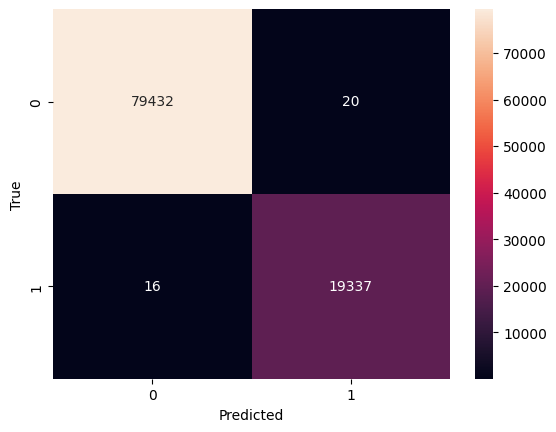

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


cm = confusion_matrix(y_val, predictions_val)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

List the logs it incorrectly predicted

In [ ]:
df_errors = pd.DataFrame({
    'True': y_val,
    'Predicted': predictions_val,
    'Features': X_val_textual  #validation features
})

df_errors = df_errors[df_errors['True'] != df_errors['Predicted']]
print(df_errors)
print(df_errors.shape)

          True Predicted                                           Features
346369  normal    attack  179 tcp telnet SF 170 1751 0 0 0 0 0 1 4 0 0 0...
91622   attack    normal  0 tcp http S2 6 144 0 0 0 1 0 1 0 0 0 0 0 0 0 ...
91929   attack    normal  0 tcp IRC REJ 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
41727   attack    normal  0 udp domain_u SF 1 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
140373  normal    attack  5046 tcp ftp_data SF 0 5134218 0 0 0 0 0 0 0 0...
91617   attack    normal  54 tcp telnet SF 260 2635 0 0 0 0 0 1 0 1 0 2 ...
136823  normal    attack  8 tcp http SF 262 285 0 0 0 0 0 1 0 0 0 0 0 0 ...
86955   normal    attack  2 tcp time SF 0 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
142293  attack    normal  0 tcp other SF 334 0 0 0 0 0 0 1 0 0 0 0 0 0 0...
66634   attack    normal  0 tcp http S0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
128693  normal    attack  605 tcp telnet SF 485 17096 0 0 0 0 0 1 4 0 0 ...
86219   attack    normal  103 tcp telnet SF 302 8876 0 0 0 2 0 1 4 1 0 3...
81597   norm